<a href="https://colab.research.google.com/github/ArchieRoche/Meta-Campaign-Analytics/blob/main/Meta_Campaign_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans
#What it does: Groups similar things together. Like what?: Imagine you have a pile of fruits (apples, bananas, oranges).
#KMeans sorts them into separate baskets based on how similar they look (e.g., all apples in one basket).
#Why use it?: To find patterns, like grouping customers who buy similar stuff.

from sklearn.preprocessing import StandardScaler
#What it does: Makes numbers fair by putting them on the same scale.
#Like what?: If you’re comparing people’s heights (in meters) and weights (in kilos), weights are bigger numbers.
#StandardScaler adjusts them so neither overshadows the other.
#Why use it?: Helps machine learning work better when numbers are different sizes.
#scaled_data = scaler.fit_transform(data) takes your raw numbers,
#learns how to make them fair, scales them so they’re on the same level (average 0, spread 1),
#and stores the result in scaled_data for your machine learning model to use.

from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LinearRegression. What it does: Predicts numbers using a straight line.
#Like what?: If you know someone’s house size, it guesses the price based on a pattern (bigger house = higher price).
#Why use it?: To predict things like sales, prices, or scores.


from sklearn.metrics import r2_score
#from sklearn.metrics import r2_score
#What it does: Tells you how good your prediction is.
#Like what?: If you predict house prices, r2_score checks how close your guesses are to the real prices. A score near 1 is awesome; near 0 is bad.
#Why use it?: To know if your LinearRegression is doing a good job.


import io
#What it does: Handles data like a virtual notepad.
#Like what?: Instead of saving a file to your computer, io lets you work with data (like a list of numbers) in memory, like a temporary scratchpad.
#Why use it?: Useful when you get data from the internet or need to process it without saving files.



In [22]:

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Create Hypothetical Database
# Simulating Meta campaign data for Heineken (Facebook and Instagram campaigns)
# Data includes campaign metrics, user demographics, and engagement data
n_records = 10000
campaign_ids = [f"camp_{i}" for i in range(1, 11)]
platforms = ['Facebook', 'Instagram']
ad_types = ['Video', 'Image', 'Carousel']
age_groups = ['18-24', '25-34', '35-44', '45-54', '55+']
genders = ['Male', 'Female', 'Other']
regions = ['North America', 'Europe', 'Asia', 'Latin America', 'Africa']

# Generate synthetic data
data = {
    'user_id': [f'user_{i}' for i in range(n_records)],
    'campaign_id': np.random.choice(campaign_ids, n_records),
    'platform': np.random.choice(platforms, n_records, p=[0.6, 0.4]),
    'ad_type': np.random.choice(ad_types, n_records, p=[0.5, 0.3, 0.2]),
    'impressions': np.random.randint(100, 10000, n_records),
    'clicks': np.random.randint(0, 500, n_records),
    'conversions': np.random.randint(0, 50, n_records),
    'spend': np.random.uniform(100, 5000, n_records).round(2),
    'age_group': np.random.choice(age_groups, n_records),
    'gender': np.random.choice(genders, n_records, p=[0.48, 0.48, 0.04]),
    'region': np.random.choice(regions, n_records),
    'engagement_time': np.random.uniform(0, 120, n_records).round(2),  # seconds
    'date': pd.date_range(start='2025-01-01', end='2025-05-15', periods=n_records).date
}

df = pd.DataFrame(data)
# Calculate derived metrics
df['ctr'] = (df['clicks'] / df['impressions'] * 100).round(2)  # Click-through rate (%)
df['cpc'] = (df['spend'] / df['clicks']).round(2).replace([np.inf, -np.inf], np.nan)  # Cost per click
df['cpa'] = (df['spend'] / df['conversions']).round(2).replace([np.inf, -np.inf], np.nan)  # Cost per acquisition
df['roas'] = (df['conversions'] * 50 / df['spend']).round(2)  # Return on ad spend (assuming $50 revenue per conversion)

# Save dataset to CSV for reproducibility
df.to_csv('heineken_meta_campaigns.csv', index=False)







In [23]:
from google.colab import files
data_to_load = files.upload()

Saving heineken_meta_campaigns.csv to heineken_meta_campaigns (2).csv


In [24]:
df=pd.read_csv('heineken_meta_campaigns.csv')

In [25]:
df

,user_id,campaign_id,platform,ad_type,impressions,clicks,conversions,spend,age_group,gender,region,engagement_time,date,ctr,cpc,cpa,roas
0,user_0,camp_7,Instagram,Video,191,249,2,4749.44,35-44,Female,Asia,108.77,2025-01-01,130.37,19.07,2374.72,0.02
1,user_1,camp_4,Instagram,Image,707,2,17,733.77,25-34,Male,Latin America,31.57,2025-01-01,0.28,366.88,43.16,1.16
2,user_2,camp_8,Facebook,Video,9543,234,9,4050.68,35-44,Male,North America,59.59,2025-01-01,2.45,17.31,450.08,0.11
3,user_3,camp_5,Instagram,Image,385,416,1,2678.71,35-44,Male,Latin America,40.23,2025-01-01,108.05,6.44,2678.71,0.02
4,user_4,camp_7,Facebook,Image,3021,442,29,4894.20,18-24,Other,North America,64.11,2025-01-01,14.63,11.07,168.77,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,user_9995,camp_7,Instagram,Video,9237,308,45,2180.53,25-34,Male,Europe,8.87,2025-05-14,3.33,7.08,48.46,1.03
9996,user_9996,camp_10,Instagram,Image,1126,63,31,648.94,18-24,Male,Europe,106.73,2025-05-14,5.60,10.30,20.93,2.39
9997,user_9997,camp_3,Facebook,Video,9815,32,45,4002.57,35-44,Male,Africa,50.50,2025-05-14,0.33,125.08,88.95,0.56
9998,user_9998,camp_10,Facebook,Image,3792,57,12,2525.83,25-34,Other,Latin America,28.75,2025-05-14,1.50,44.31,210.49,0.24


# Exploratory Data Analysis (EDA)

In [26]:
#EDA

df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          10000 non-null  object 
 1   campaign_id      10000 non-null  object 
 2   platform         10000 non-null  object 
 3   ad_type          10000 non-null  object 
 4   impressions      10000 non-null  int64  
 5   clicks           10000 non-null  int64  
 6   conversions      10000 non-null  int64  
 7   spend            10000 non-null  float64
 8   age_group        10000 non-null  object 
 9   gender           10000 non-null  object 
 10  region           10000 non-null  object 
 11  engagement_time  10000 non-null  float64
 12  date             10000 non-null  object 
 13  ctr              10000 non-null  float64
 14  cpc              9977 non-null   float64
 15  cpa              9808 non-null   float64
 16  roas             10000 non-null  float64
dtypes: float64(6)

,impressions,clicks,conversions,spend,engagement_time,ctr,cpc,cpa,roas
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,9977.000000,9808.000000,10000.000000
mean,5025.762100,250.873000,24.432300,2577.234264,59.766128,12.144000,34.619691,243.151074,0.967784
std,2865.339291,143.927008,14.388458,1412.784358,34.873261,28.981746,162.748921,504.963809,1.778999
min,100.000000,0.000000,0.000000,100.630000,0.010000,0.000000,0.210000,2.170000,0.000000
25%,2515.000000,126.000000,12.000000,1357.902500,29.127500,2.510000,5.370000,54.417500,0.230000
50%,5011.500000,252.000000,24.000000,2580.025000,60.080000,4.980000,10.290000,102.810000,0.480000
75%,7537.500000,376.000000,37.000000,3812.955000,90.217500,9.880000,20.370000,204.237500,0.900000
max,9999.000000,499.000000,49.000000,4999.320000,120.000000,476.000000,4925.100000,4938.670000,23.050000


In [27]:
df.isnull().sum()

,0
user_id,0
campaign_id,0
platform,0
ad_type,0
impressions,0
clicks,0
conversions,0
spend,0
age_group,0
gender,0


In [28]:
df.columns

Index(['user_id', 'campaign_id', 'platform', 'ad_type', 'impressions',
       'clicks', 'conversions', 'spend', 'age_group', 'gender', 'region',
       'engagement_time', 'date', 'ctr', 'cpc', 'cpa', 'roas'],
      dtype='object')

#Visualise distribution of campaign spend

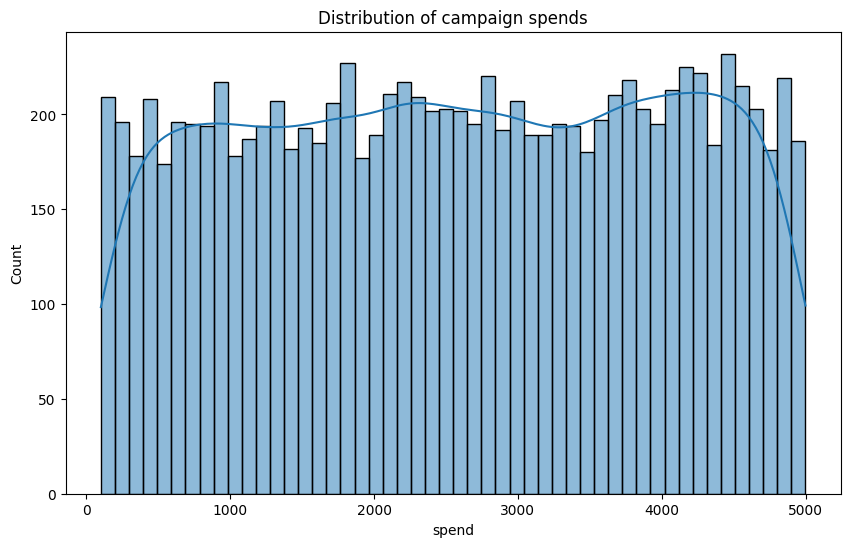

In [29]:
#Visual destribution of campaign. spends

plt.figure(figsize=(10,6))
sns.histplot(df['spend'],bins=50,kde=True)
plt.title('Distribution of campaign spends')
plt.xlabel=('spends')
plt.ylabel=('frequency')
plt.show()


The spend distribution appers roughly uniform across the range of $100 to $5000 spends.

There are minor peaks and troughs in the histogram, with slight increase in frequenct around 500, 2500 and 4500, and dips around $1500 to $3500


In [30]:
print("== Campaign Spend Statistics ==")
print(df['spend'].describe())


== Campaign Spend Statistics ==
count    10000.000000
mean      2577.234264
std       1412.784358
min        100.630000
25%       1357.902500
50%       2580.025000
75%       3812.955000
max       4999.320000
Name: spend, dtype: float64


#Distribution of Campaign Spend by Platforms

#Observation
Range:
USD 100 to USD 4999

Mean Spend:
~ USD 2577, close to the midpoint of the range (USD 100 to USD 5000), confirming the uniform distribution.

Standard Deviation:
~ USD 1412, indicating a wide spread, as expected from a uniform distribution.

Quartiles:
25th percentile: ~ USD 1357 (lowest-budget campaigns)

Median (50th percentile): approx USD 2580 (50% of the campaign records (5,000 out of 10,000) have a spend of USD 2580 or less. This is the midpoint of the spend distribution, meaning half the records are below USD 2580 and half are above.

75th percentile: ~ USD 3812 : 75% of the campaign records (7,500 out of 10,000) have a spend of USD 3812 or less.  

#the majority of campaigns are spending below $3812, while the top 25% are spending between USD 3812  and USD 5000.

Middle 50% (IQR): 50% of the campaign records (the middle 5,000 records) have spends between $1357 and $3773.


#Inference/Conclusion
The uniform distribution suggests that campaign spends are evenly distributed across the budget range, which might indicate a lack of strategic allocation
(e.g., no preference for low-budget testing vs. high-budget campaigns)


#1. Budget Distribution
Heineken is not prioritizing high-performing campaigns. They should allocate more budget to campaigns with higher ROAS or CTR, rather than spreading spends evenly.

#2. Spending Patterns
Low Spends (Bottom 25%, USD 100 - USD1357): These might represent smaller test campaigns or low-budget ad sets. Heineken should evaluate their performance (e.g., CTR, ROAS) to determine if they are worth scaling.

Middle Spends (Middle 50%, USD 1357- USD3773): The majority of campaigns fall in this range. This is a good range for balanced testing and scaling, as it avoids over-investment in unproven campaigns while providing enough budget to drive results.

High Spends (Top 25%, USD 3773- USD 5000): These are the highest-budget campaigns. Heineken should ensure these are allocated to high-performing campaigns

#3.Optimization Opportunity:
The uniform spend distribution indicates a lack of strategic focus. Heineken can optimize by reallocating budget from the bottom 25% (low spends with potentially low returns) to the top 25% (high spends on high-performing campaigns),


#Visualize Campaign Spend by Platform

---



TypeError: 'str' object is not callable

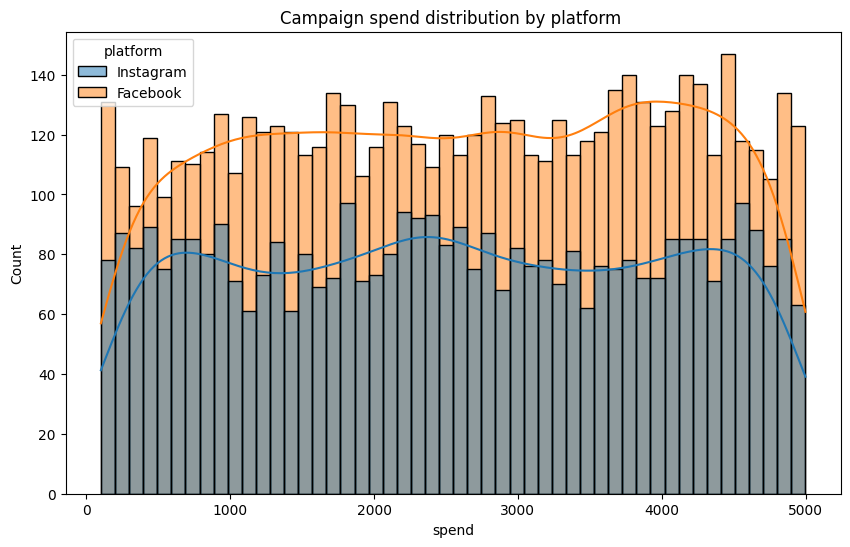

In [31]:
plt.figure(figsize=(10,6))
sns.histplot(x='spend', data=df, hue='platform', kde=True, bins=50)
plt.title('Campaign spend distribution by platform ')
plt.xlabel('Platform spends')
plt.ylabel('Count')
plt.show()

# :Visualise campaign spend by Campaign Id

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='campaign_id', y='spend', data=df)
plt.title('Spend Distribution by Campaign')
plt.xlabel('Campaign ID')
plt.ylabel('Spend ($)')
plt.xticks(rotation=45)
plt.show()

each campaigns box plot has a similar median ( approx 2500) and IQR ( from approx 1324 to 3773) . With whiskers tending to the full range ( $100 to $5000).
This uniformity suggests that budgets are not strategically allocated based on campaign performance.

#Deeper Analysis: Spend Distribution by Platform and Campaign ID
To gain more insights, we break down the spend distribution by platform and campaign ID to identify patterns that might inform optimization.


In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='spend', hue='platform', bins=50, kde=True)
plt.title('Distribution of Campaign Spends by Platform')
plt.xlabel('Spend ($)')
plt.ylabel('Count')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='platform', y='ctr',data=df)
plt.title('CTR by platform')
plt.xlabel('CTR')
plt.ylabel('platform')
plt.show()

#Correlation matrix of key metrics

In [ ]:
plt.figure(figsize=(10,8))
key_metrics= ['impressions','clicks', 'conversions','engagement_time','spend','ctr', 'cpc', 'cpa', 'roas']
corr_matrix=df[key_metrics].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

#annot=True: Shows the actual numbers (like 0.95, 1.00) in each cell of the heatmap. Without this, you’d only see colors.
#fmt='.2f': Formats the numbers shown in the cells to have 2 decimal places (e.g., 0.95 instead of 0.947368). This makes the heatmap easier to read.
plt.title('Correlation Matrix of Key Metrics')
plt.show()

#Impressions and Conversions by Age Group


#Impressions

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='age_group', y='impressions', data=df)
plt.title('Impressions by Age Group')
plt.show()


Similar Medians Across Age Groups:
The median (the line inside each box) for impressions is around 6,000–7,000 for all age groups.
#Insight: On average, all age groups have roughly the same typical number of impressions (around 6,000–7,000). No single age group stands out as having much higher or lower median impressions.

Similar Spread Across Age Groups:
The boxes (middle 50% of data) for all age groups span roughly from 4,000 to 8,000 impressions.
The whiskers (range of most data) extend from around 2,000 to 10,000 for most groups.
#Insight: The variation in impressions is similar across all age groups. Most impressions fall between 2,000 and 10,000, with the middle 50% between 4,000 and 8,000. No age group has a much wider or narrower range.


No Outliers Visible:
There are no dots outside the whiskers, which means there are no extreme values (outliers) in impressions for any age group.
#Insight: The data is fairly consistent within each age group—no unusually high or low impressions that stand out as anomalies.


Slight Differences in Boxes and Whiskers:
The 18-24 group has a slightly shorter box (less variation in the middle 50%) and whiskers that don't extend as low as others (minimum around 3,000 vs. 2,000 for others).
The 55+ group has a slightly longer box, suggesting a bit more variation in the middle 50% of impressions.
#Insight: The 18-24 age group has a bit less variation in impressions, with fewer low values (no impressions below 3,000). The 55+ group shows a bit more variation, with a wider range in the middle 50%.

All age groups have very similar boxplot shapes, medians, and ranges.
#Insight: Impressions are distributed fairly evenly across age groups—there’s no major difference in how ads are performing for different ages.

Impressions are consistent across age groups:
"Ad impressions are evenly distributed across all age groups, with median impressions ranging between 6,000 and 7,000 for each group. This suggests that our ad campaigns are reaching all age demographics with similar visibility."

No age group dominates impressions:
"No single age group stands out as receiving significantly higher or lower impressions. The middle 50% of impressions for all groups fall between 4,000 and 8,000, indicating balanced ad exposure across ages."


18-24 group has less variation:
"The 18-24 age group shows slightly less variation in impressions, with no values below 3,000 and a tighter middle 50% range. This could indicate more consistent ad performance for younger audiences, possibly due to targeted campaigns or higher engagement."


55+ group has slightly more variation:
"The 55+ age group has a slightly wider range in the middle 50% of impressions, suggesting more variability in how ads perform for this demographic. This might reflect inconsistent engagement or differences in platform usage among older users."


No outliers in the data:
"There are no outliers in impressions for any age group, indicating that our ad campaigns are performing consistently without extreme spikes or drops in visibility for any demographic."


Opportunity for optimization:
#Since impressions are similar across all age groups, we may not need to adjust ad distribution by age. However, the slight consistency in the 18-24 group suggests they might be a reliable target for campaigns needing predictable reach, while the 55+ groups variability might require more tailored strategies to ensure consistent performance.

#Conversions

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='age_group', y='conversions', data=df)
plt.title('Conversions by Age Group')
plt.show()

#Engagement Time by Region and Gender


TypeError: 'str' object is not callable

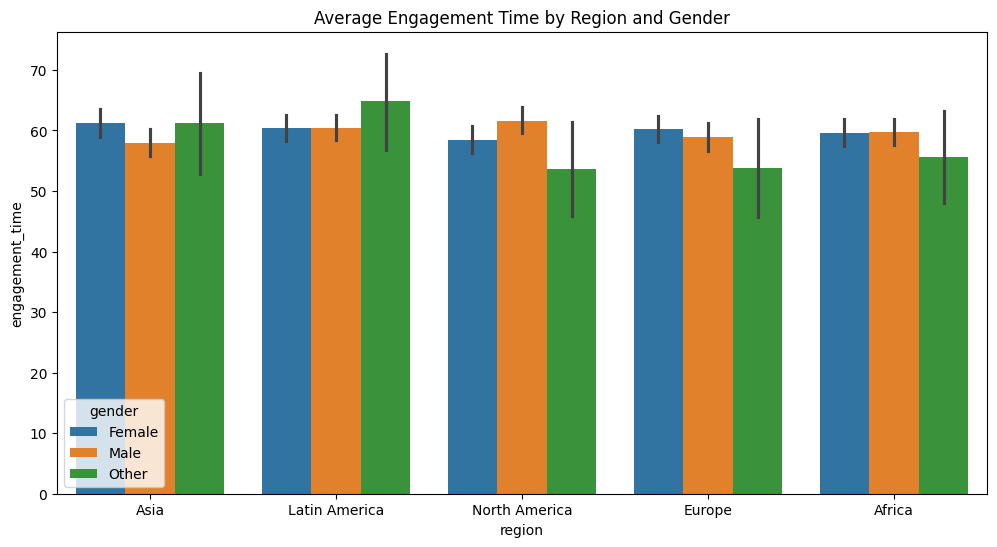

In [32]:
plt.figure(figsize=(12, 6))
sns.barplot(x='region', y='engagement_time', hue='gender', data=df)
plt.title('Average Engagement Time by Region and Gender')
plt.xlabel('Region')
plt.ylabel('Engagement Time (seconds)')
plt.show()

#Time Series Analysis of Spend and Conversions

TypeError: 'str' object is not callable

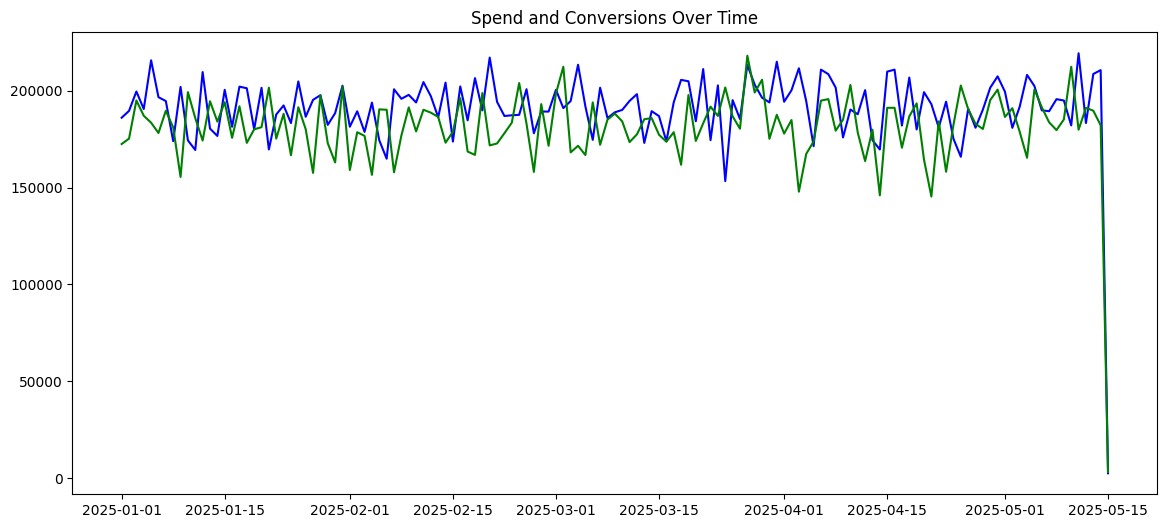

In [33]:
df['date'] = pd.to_datetime(df['date'])
time_series = df.groupby('date').agg({'spend': 'sum', 'conversions': 'sum'}).reset_index()

plt.figure(figsize=(14, 6))
plt.plot(time_series['date'], time_series['spend'], label='Spend ($)', color='blue')
plt.plot(time_series['date'], time_series['conversions'] * 100, label='Conversions (scaled)', color='green')  # Scaled for visibility
plt.title('Spend and Conversions Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Ad Type Performance by Region

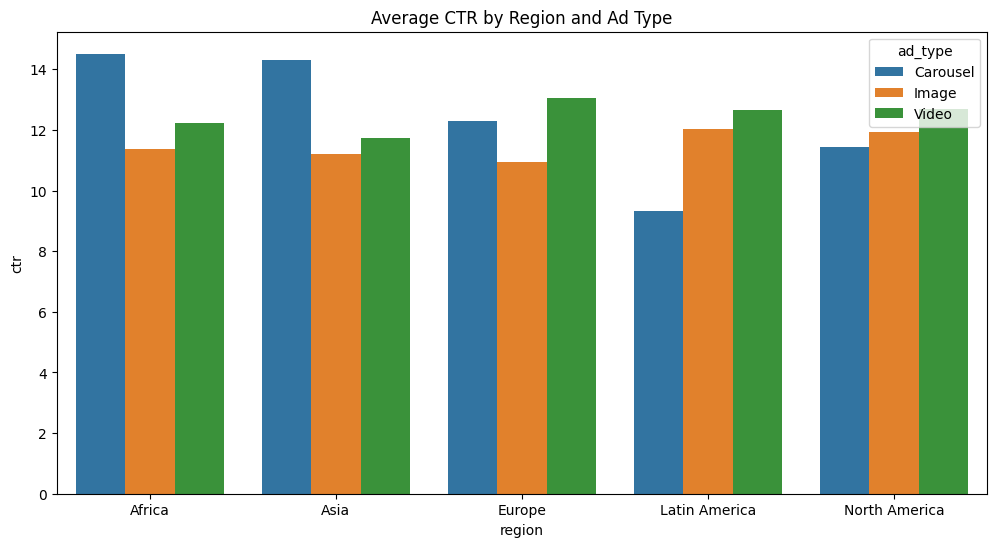

In [34]:
ad_region_performance = df.groupby(['region', 'ad_type']).agg({
    'ctr': 'mean',
    'roas': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='region', y='ctr', hue='ad_type', data=ad_region_performance)
plt.title('Average CTR by Region and Ad Type')
plt.show()

#Missing Data Analysis

In [35]:
print("\n=== Missing Data Analysis ===")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])


=== Missing Data Analysis ===
cpc     23
cpa    192
dtype: int64


#Outlier Detection for Spend

TypeError: 'str' object is not callable

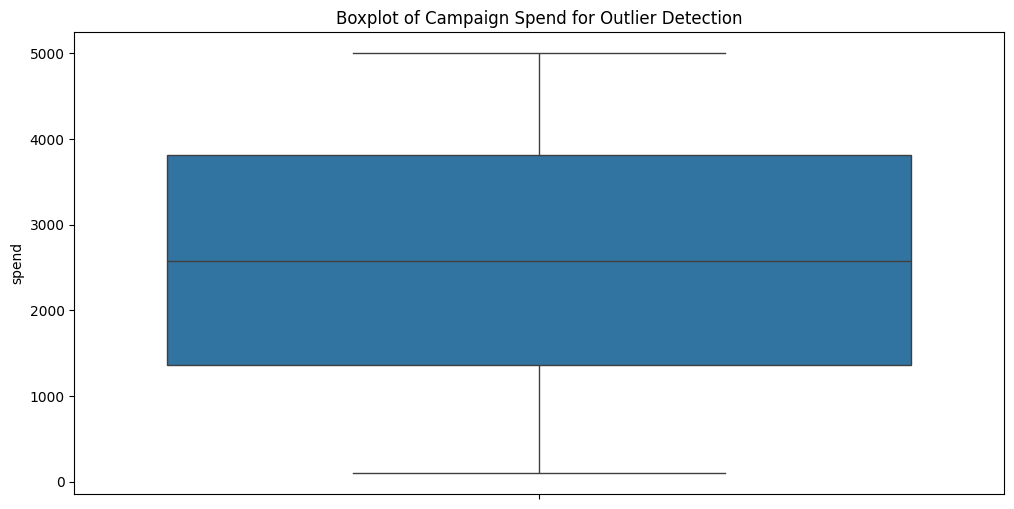

In [36]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='spend', data=df)
plt.title('Boxplot of Campaign Spend for Outlier Detection')
plt.ylabel('Spend ($)')
plt.show()